In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('ggplot')

%matplotlib inline
#mpl.get_backend()

np.set_printoptions(precision=2)

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('../data/trend_usetime.csv', sep='\t', index_col=0, parse_dates=True)
df.head()

,usetime
week,
2016-01-04,9.510413e+07
2016-01-11,9.171474e+07
2016-01-18,9.260616e+07
2016-01-25,8.990846e+07
2016-02-01,8.730220e+07


In [3]:
ts = df['usetime']

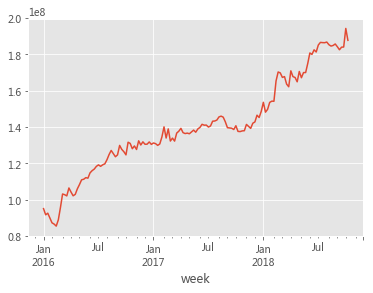

In [4]:
ts.plot()

In [5]:
def test_stationarity(timeseries):
    '''
    1. 绘制滚动统计 均值&&方差
    2. Dickey-Fuller Test
    '''
    #Determing rolling statistics
    #这个写法已不支持
    #rolmean = pd.rolling().mean(timeseries, window=12) 
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

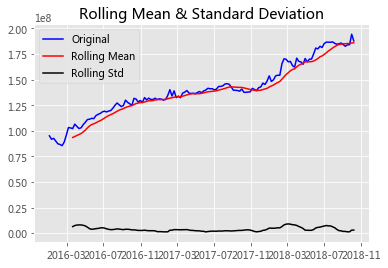

Results of Dickey-Fuller Test:
Test Statistic                  -0.555607
p-value                          0.880701
#Lags Used                       1.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64


In [6]:
test_stationarity(ts)

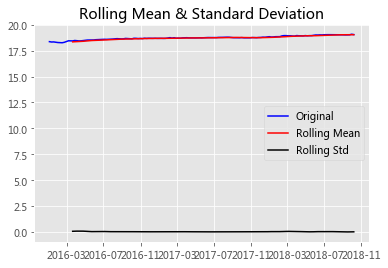

Results of Dickey-Fuller Test:
Test Statistic                  -1.726842
p-value                          0.417339
#Lags Used                       3.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64


In [7]:
ts_log = np.log(ts)
test_stationarity(ts_log)

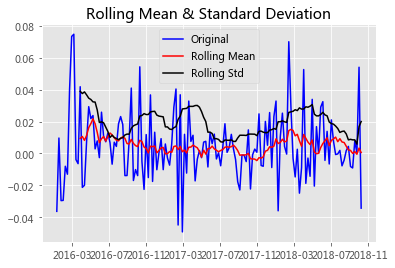

Results of Dickey-Fuller Test:
Test Statistic                -7.752375e+00
p-value                        9.941323e-12
#Lags Used                     2.000000e+00
Number of Observations Used    1.410000e+02
Critical Value (1%)           -3.477601e+00
Critical Value (5%)           -2.882266e+00
Critical Value (10%)          -2.577822e+00
dtype: float64


In [8]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

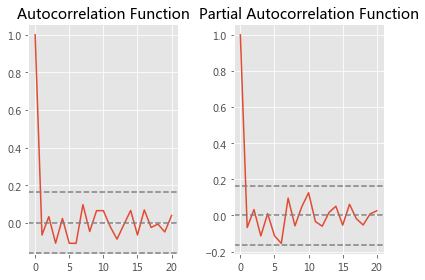

In [9]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 0.0654')

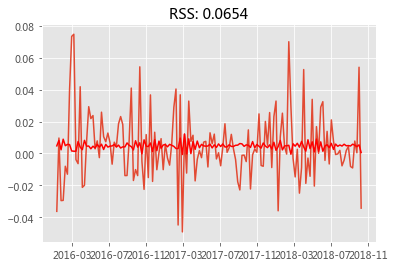

In [10]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

week
2016-01-11    0.004762
2016-01-18    0.008205
2016-01-25    0.002287
2016-02-01    0.008943
2016-02-08    0.004871
dtype: float64


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


Text(0.5,1,'RMSE: 8452161.2209')

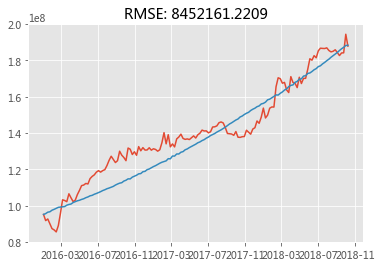

In [11]:

#ARIMA拟合的其实是一阶差分ts_log_diff，predictions_ARIMA_diff[i]是第i个月与i-1个月的ts_log的差值。
#由于差分化有一阶滞后，所以第一个月的数据是空的，
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())
#累加现有的diff，得到每个值与第一个月的差分（同log底的情况下）。
#即predictions_ARIMA_diff_cumsum[i] 是第i个月与第1个月的ts_log的差值。
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#先ts_log_diff => ts_log=>ts_log => ts 
#先以ts_log的第一个值作为基数，复制给所有值，然后每个时刻的值累加与第一个月对应的差值(这样就解决了，第一个月diff数据为空的问题了)
#然后得到了predictions_ARIMA_log => predictions_ARIMA
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure()
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))